In [1]:
import os
import sys
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from sklearn.decomposition import PCA
import seaborn as sns
import datetime
from scipy.stats import sem
import matplotlib.cm as cm
import pathlib
import traceback
import gc
from data.ValidationDataset import NoisyDataset

In [73]:
import pdb

# Load PCA

In [2]:
netname = 'pnet'
engram_dir = '/mnt/smb/locker/abbott-locker/hcnn/'
activations_dir = f'{engram_dir}3_activations/{netname}/'
pca_activations_dir = f'{engram_dir}4_activations_pca/{netname}/'
bg_types = ['pinkNoise', 'AudScene', 'Babble8Spkr']
snr_types = [-9.0, -6.0, -3.0, 0.0, 3.0]

# Helper functions

In [75]:
def get_data(conv_idx, t, bg, snr):
    activ_dir = f'{activations_dir}{bg}_snr{int(snr)}/'
    for results_file in os.listdir(activ_dir):
        results_filepath = f'{activ_dir}{results_file}'
        results = h5py.File(results_filepath, 'r')
    if conv_idx > 3:
        activ = np.array(results[f'conv{conv_idx}_W_{t}_activations'])
    else:
        activ = np.array(results[f'conv{conv_idx}_{t}_activations'])
    n_data = activ.shape[0]
    activ = activ.reshape((n_data, -1))
    
    # Repeat for clean
    if conv_idx > 3:
        clean_activ = np.array(results[f'conv{conv_idx}_W_{t}_clean_activations'])
    else:
        clean_activ = np.array(results[f'conv{conv_idx}_{t}_clean_activations'])
    clean_activ = clean_activ.reshape((n_data, -1))
    
    return activ, clean_activ, np.array(results['label'])

# Measure invariance

In [78]:
bgs = []
snrs = []
convs = []
ts = []
clean_noise_dist = []
utterance_dist = []
clean_clean_dist = []
for bg in bg_types:
    for snr in snr_types:
        for conv_idx in [1,2,3,4,5]:
            for t in [0,1,2,3,4]:
                activ, clean_activ, label = get_data(conv_idx, t, bg, snr)
                bgs.append(bg)
                snrs.append(snr)
                convs.append(conv_idx)
                ts.append(t)
                
                # Clean-noisy distance for same audio clip
                _clean_noise_dist = []
                for idx in range(len(activ)):
                    _clean_noise_dist.append(np.square(activ[idx] - clean_activ[idx]))
                _clean_noise_dist = np.mean(_clean_noise_dist, axis=0)
                _clean_noise_dist = np.sum(_clean_noise_dist)
                clean_noise_dist.append(_clean_noise_dist)
                
                # Distance between utterances of the same word
                _utterance_dist = []
                for l in np.unique(label):
                    utterance_activ = clean_activ[label==l]
                    for i in range(utterance_activ.shape[0]):
                        for j in range(0,i):
                            _utterance_dist.append(np.square(
                                utterance_activ[i] - utterance_activ[j]))
                _utterance_dist = np.mean(_utterance_dist, axis=0)
                _utterance_dist = np.sum(_utterance_dist)
                utterance_dist.append(_utterance_dist)
                
                # Distance between any two clean audio clips
                _clean_clean_dist = []
                for idx in range(len(activ)):
                    rand_idx = np.random.choice(len(activ))
                    _clean_clean_dist.append(np.square(
                        clean_activ[idx] - clean_activ[rand_idx]))
                _clean_clean_dist = np.mean(_clean_clean_dist, axis=0)
                _clean_clean_dist = np.sum(_clean_clean_dist)
                clean_clean_dist.append(_clean_clean_dist)

In [123]:
invariance_df = pd.DataFrame({
    'BG': bgs,
    'SNR': snrs,
    'Conv': convs,
    'T': ts,
    'Dist': clean_noise_dist,
    'Invariance by Utterance': np.array(clean_noise_dist)/np.array(utterance_dist),
    'Invariance by Radius': np.array(clean_noise_dist)/np.array(clean_clean_dist),
    })

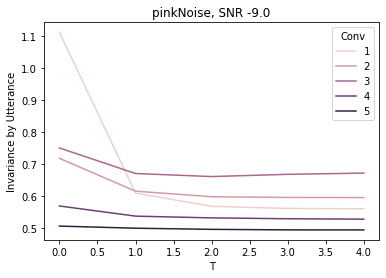

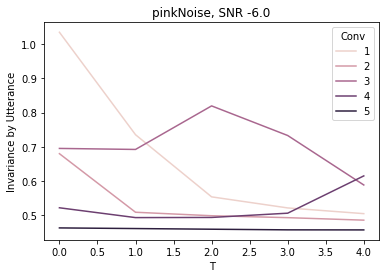

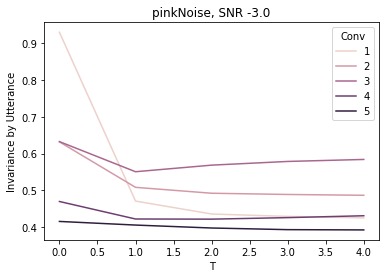

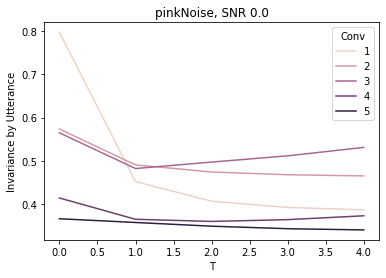

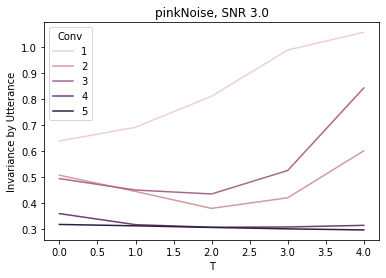

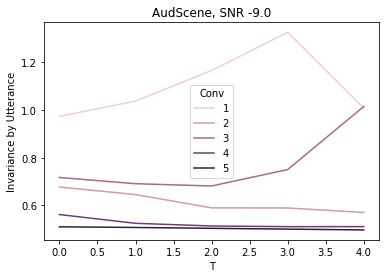

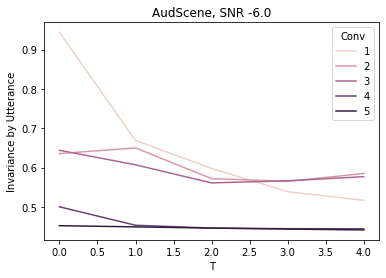

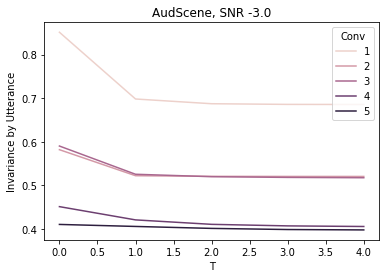

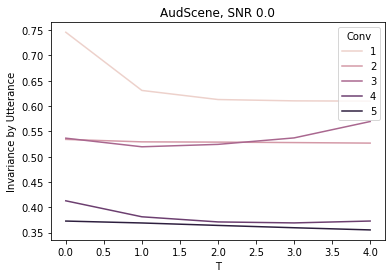

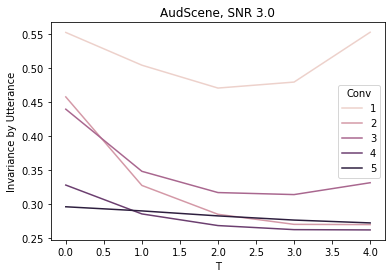

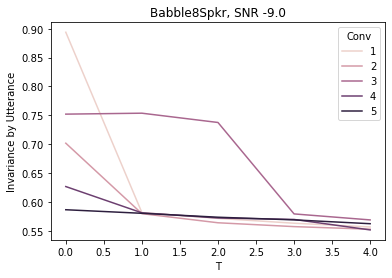

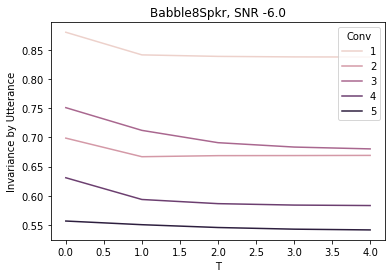

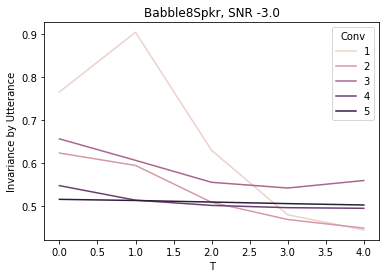

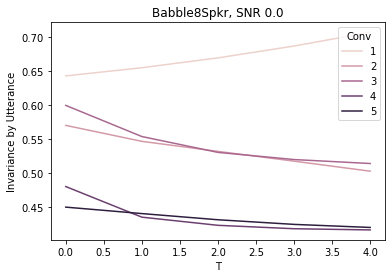

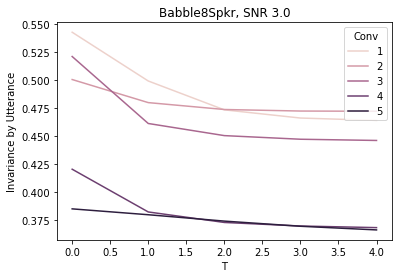

In [99]:
for bg in bg_types:
    for snr in snr_types:
        fig, ax = plt.subplots()
        sns.lineplot(
            x='T', y='Invariance by Utterance', hue='Conv',
            data=invariance_df[(invariance_df['BG']==bg) & (invariance_df['SNR']==snr)],
            ax=ax)
        ax.set_title(f'{bg}, SNR {snr}')

# Measure factorization

In [131]:
bgs = []
snrs = []
convs = []
ts = []
factorization = []
for bg in bg_types:
    for snr in snr_types:
        for conv_idx in [1,2,3,4,5]:
            for t in [0,1,2,3,4]:
                activ, clean_activ, label = get_data(conv_idx, t, bg, snr)
                bgs.append(bg)
                snrs.append(snr)
                convs.append(conv_idx)
                ts.append(t)
                
                clean_pca_path = f'{pca_activations_dir}PCA_clean_conv{conv_idx}_t{t}.p'
                with open(clean_pca_path, 'rb') as f:
                    clean_pca = pickle.load(f)
                clean_cum_var = np.cumsum(clean_pca.explained_variance_ratio_)
                K = np.argwhere(clean_cum_var>0.9)[0].item()
                cum_var_K = clean_cum_var[K]
                activ_centered = activ - clean_pca.mean_[None,:]
                total_var = np.sum(np.square(activ_centered))/(activ.shape[0]-1)
                explained_variance = []
                for k in range(K+1):
                    var = np.sum(np.square(
                        activ_centered @ clean_pca.components_[k]))/(activ.shape[0]-1)
                    explained_variance.append(var)
                clean_explained = np.sum(explained_variance)/total_var
                _factorization = 1 - clean_explained/cum_var_K
                factorization.append(_factorization)

In [133]:
invariance_df = pd.DataFrame({
    'BG': bgs,
    'SNR': snrs,
    'Conv': convs,
    'T': ts,
    'Factorization': factorization,
    })

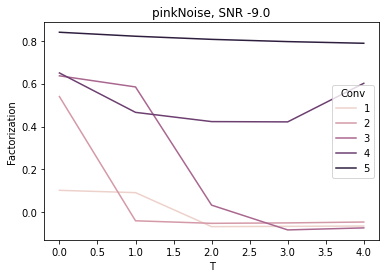

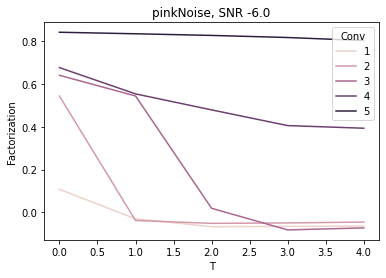

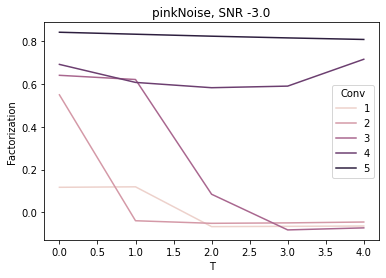

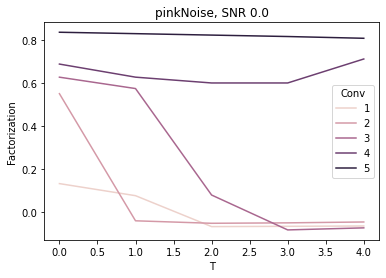

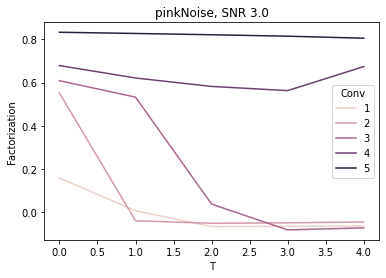

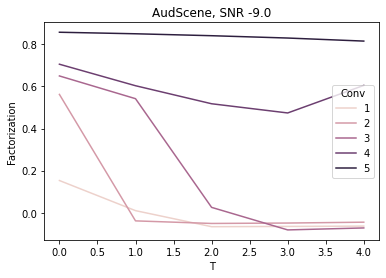

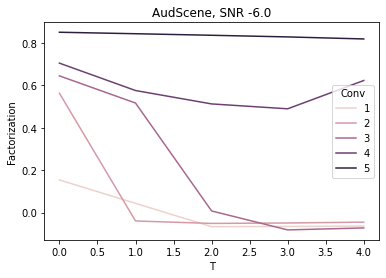

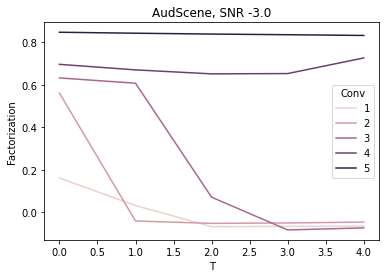

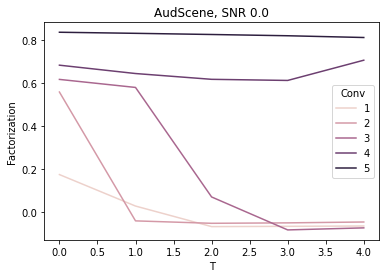

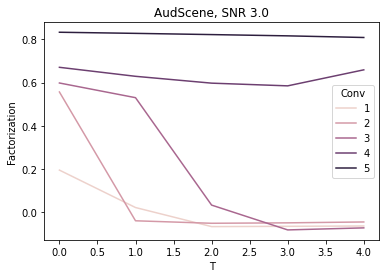

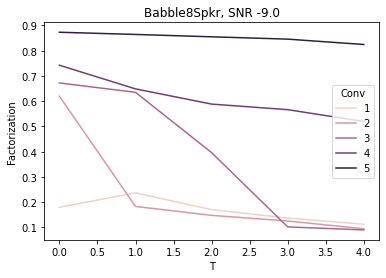

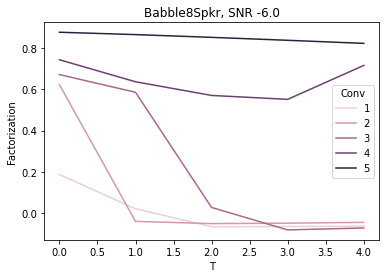

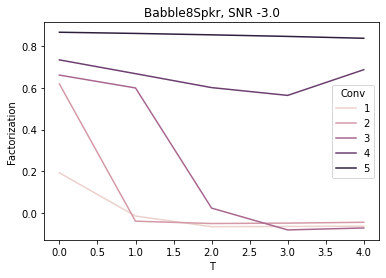

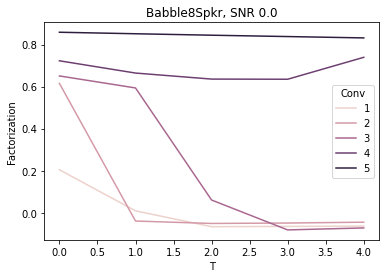

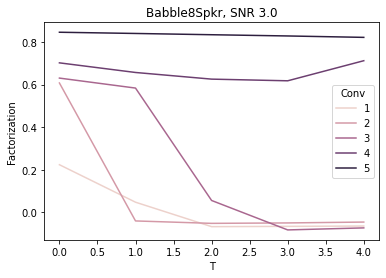

In [134]:
for bg in bg_types:
    for snr in snr_types:
        fig, ax = plt.subplots()
        sns.lineplot(
            x='T', y='Factorization', hue='Conv',
            data=invariance_df[(invariance_df['BG']==bg) & (invariance_df['SNR']==snr)],
            ax=ax)
        ax.set_title(f'{bg}, SNR {snr}')

In [135]:
factorization

[0.10270691138069943,
 0.09191392551106992,
 -0.06652964853727794,
 -0.06516387579137506,
 -0.0636656400569311,
 0.5396563538871808,
 -0.03923647446271117,
 -0.0510751784136525,
 -0.049075398469867526,
 -0.045021533262016744,
 0.6362179395427565,
 0.5844335648149676,
 0.033633819796726305,
 -0.08177726937592555,
 -0.07234017852521557,
 0.6495920455917464,
 0.466028486360609,
 0.42295268340107917,
 0.4216014232686486,
 0.6014560095770984,
 0.8393033416939052,
 0.820711076479297,
 0.8061596307386933,
 0.7957150725257705,
 0.7879230769746548,
 0.10808247423844586,
 -0.029660792573804384,
 -0.06663771269806484,
 -0.06526719494600419,
 -0.06367956926203822,
 0.5438566427606607,
 -0.03766168551330873,
 -0.05101374563177341,
 -0.04907904641273775,
 -0.04504206449174997,
 0.6410829929232815,
 0.5444168650992129,
 0.019370131399630508,
 -0.08168900033267978,
 -0.07231209289145757,
 0.6769312788444115,
 0.5541527567676434,
 0.4793096207398496,
 0.4059198283667378,
 0.39361624140023865,
 0.842203